### Imports

In [1]:
import sys
import os
script_dir = os.getcwd()
root_dir = os.path.join(os.path.dirname(os.path.abspath(script_dir)))
sys.path.append(os.path.join(os.path.dirname(os.path.abspath(script_dir))))

import json
import pandas as pd
import numpy as np
from utils.io import load_object, save_object
from utils.evaluation import calc_eval_metrics
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc
from statsmodels.stats.multitest import multipletests


### Manuscript Figures and Results

#### Figure 2A. Accuracy of LLM across various prompt strategies

In [98]:
moalmanac_data=pd.read_csv(os.path.join(root_dir, 'data/moa_fda_queries_answers.csv'), index_col=0)
synthetic_prompt_groundtruth_dict=load_object(os.path.join(root_dir, 'data/synthetic_prompt_groundtruth_dict.pkl'))

In [99]:
llm_mistnemo_res_dict_0 = load_object(filename=os.path.join(root_dir, 'output/LLM_res_mistnemo/stra0n1temp0.0_res_dict.pkl'))
llm_mistnemo_res_dict_1 = load_object(filename=os.path.join(root_dir, 'output/LLM_res_mistnemo/stra1n1temp0.0_res_dict.pkl'))
llm_mistnemo_res_dict_2 = load_object(filename=os.path.join(root_dir, 'output/LLM_res_mistnemo/stra2n1temp0.0_res_dict.pkl'))
llm_mistnemo_res_dict_3 = load_object(filename=os.path.join(root_dir, 'output/LLM_res_mistnemo/stra3n1temp0.0_res_dict.pkl'))

In [100]:
plot_res = pd.DataFrame(
    {
    'Basic_prompt' : [calc_eval_metrics(llm_mistnemo_res_dict_0['full output'][0], moalmanac_data['prompt'], synthetic_prompt_groundtruth_dict)['avg_partial_match_acc']],
    'Basic_prompt_condition' : [calc_eval_metrics(llm_mistnemo_res_dict_1['full output'][0], moalmanac_data['prompt'], synthetic_prompt_groundtruth_dict)['avg_partial_match_acc']],
    'Basic_prompt_system' : [calc_eval_metrics(llm_mistnemo_res_dict_2['full output'][0], moalmanac_data['prompt'], synthetic_prompt_groundtruth_dict)['avg_partial_match_acc']],
    'Basic_prompt_combined' : [calc_eval_metrics(llm_mistnemo_res_dict_3['full output'][0], moalmanac_data['prompt'], synthetic_prompt_groundtruth_dict)['avg_partial_match_acc']]
    }
    )
    
plot_res = plot_res.iloc[0,:].to_frame()
plot_res[1] = plot_res[0]*100
print(plot_res)

                               0          1
Basic_prompt            0.692308  69.230769
Basic_prompt_condition  0.534188  53.418803
Basic_prompt_system     0.645299  64.529915
Basic_prompt_combined   0.512821  51.282051


In [101]:
plot_res[1].rename(index={
    'Basic_prompt':'(1) Basic prompt',
    'Basic_prompt_condition':'(2) Basic prompt + condition',
    'Basic_prompt_system':'(3) Basic prompt + system role',
    'Basic_prompt_combined':'(4) Basic prompt + (2) + (3)'
                          }, inplace=True)


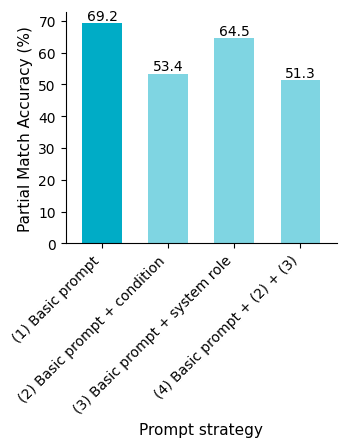

In [104]:
# set figure size
plt.rcParams["figure.figsize"] = [3.5, 3]

# set color palette
cols=sns.color_palette(cc.glasbey, n_colors=40)

# create bar plot
ax=plot_res[1].plot(kind='bar', color=cols[3], width=0.6, legend=False)

# add text
for i, v in enumerate(plot_res[1]):
    ax.text(x=i, y=v+0.05, s=f'{v:.1f}', ha='center', va='bottom', fontsize=10)

# x, y label and ticks
ax.set_xlabel('Prompt strategy', fontsize=11)
ax.set_ylabel('Partial Match Accuracy (%)', fontsize=11)
plt.xticks(rotation=45, ha='right')

# borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# highlight first bar
ax.patches[0].set_facecolor(cols[3])

# set alpha for the rest of the bars
for i, patch in enumerate(ax.patches):
    if i != 0:  
        patch.set_alpha(0.5) 

# save
save = True
if save == True:
    plt.savefig('./figures/Figure2_accuracyLLMprompt.jpeg', dpi=500, bbox_inches='tight')

plt.show()

#### Figure 2B. Accuracy of LLMs of various sizes across prompt strategies

##### Statistical test on basic vs. combination prompts

In [105]:
# Load McNemar package
from statsmodels.stats.contingency_tables import mcnemar

# Function to create a contingency matrix for McNemar's test
def create_mcnemar_table(y_pred_A, y_pred_B):
    
    # Convert to numpy arrays for easy element-wise comparison
    y_pred_A = np.array(y_pred_A)
    y_pred_B = np.array(y_pred_B)

    # Compute contingency table values
    a = np.sum((y_pred_A == True) & (y_pred_B == True)) # Both correct
    b = np.sum((y_pred_A == True) & (y_pred_B == False)) # A correct, B incorrect
    c = np.sum((y_pred_A == False) & (y_pred_B == True)) # A incorrect, B correct
    d = np.sum((y_pred_A == False) & (y_pred_B == False)) # Both incorrect

    # Create contingency table
    table = np.array([[a, b], [c, d]])

    return(table)

In [106]:
# Load LLM-only outputs and evaluate
models = ['mist7B', 'mist8B', 'mistnemo', 'mistlarge', 'gptmini', 'gpt4o', 'o4mini']
strategies = [0, 3]

llm_output_dicts = {}
llm_eval_res = {}
partial_acc_dicts = {}

for model in models:
    model_eval = {}
    for strategy in strategies:
        output_key = f"llm_{model.lower()}_res_dict_{strategy}"
        eval_key = f"llm_{model.lower()}_eval_res_{strategy}"
        
        # Load LLM outputs
        path = os.path.join(root_dir, f'output/LLM_res_{model}/stra{strategy}n1temp0.0_res_dict.pkl')
        llm_output_dicts[output_key] = load_object(filename=path)
        
        # Evaluate LLM outputs
        eval_result = calc_eval_metrics(llm_output_dicts[output_key]['full output'][0], moalmanac_data['prompt'], synthetic_prompt_groundtruth_dict)
        llm_eval_res[eval_key] = eval_result
        
        # Save each model's results
        model_eval[strategy] = {'partial_match_acc':eval_result['partial_match_acc'], 'avg_partial_match_acc':eval_result['avg_partial_match_acc']}
        
    partial_acc_dicts[f"{model}_partial_acc_dict"] = model_eval
    

In [107]:
# Create contingency table for mcnemar's test
mcnemar_tables = {}
for model in models:
    mcnemar_tables[f'{model}_partial_table'] = create_mcnemar_table(
        partial_acc_dicts[f'{model}_partial_acc_dict'][3]['partial_match_acc'], 
        partial_acc_dicts[f'{model}_partial_acc_dict'][0]['partial_match_acc']
    )
    

In [108]:
# Perform McNemar's test (use exact=True if b+c < 25)
def conduct_mcnemar_test(table):
    b, c = table[[0,1],[1,0]]
    if b+c < 25:
        result = mcnemar(table, exact=True, correction=True) 
    else:
        result = mcnemar(table, exact=False, correction=True)
    discordants = {'b':b, 'c':c}
    return(result, discordants)

# Print results
def print_mcnemar_res(mcnemar_result, alpha):
    significance = mcnemar_result.pvalue < alpha
    
    return f"Significance: {significance}; Test Statistic: {mcnemar_result.statistic}; P-value: {mcnemar_result.pvalue}"


In [109]:
# Run McNemar and get accuracies
model_labels = dict(zip(models, ['mist_7B', 'mist_8B', 'mistnemo_12B', 'mistlarge_123B', 'gpt4omini', 'gpt4o','o4mini']))

mcnemar_result = {}
accuracy = {}
p_values = {}

for model, label in model_labels.items():
    # Run McNemar's test
    mcnemar_result[f'{model}_mcnemar_res'], _ = conduct_mcnemar_test(mcnemar_tables[f'{model}_partial_table'])
    print(print_mcnemar_res(mcnemar_result[f'{model}_mcnemar_res'], alpha=0.05))

    # Get p-values
    p_values[label] = mcnemar_result[f'{model}_mcnemar_res'].pvalue
    
    # Get accuracies
    accuracy[label] = [
        partial_acc_dicts[f'{model}_partial_acc_dict'][0]['avg_partial_match_acc'], 
        partial_acc_dicts[f'{model}_partial_acc_dict'][3]['avg_partial_match_acc']
    ]

Significance: False; Test Statistic: 2.938775510204082; P-value: 0.08647626549366548
Significance: False; Test Statistic: 2.56; P-value: 0.10959858339911568
Significance: True; Test Statistic: 38.20454545454545; P-value: 6.370385309896191e-10
Significance: False; Test Statistic: 5.0; P-value: 0.30175781249999994
Significance: False; Test Statistic: 5.0; P-value: 0.09625244140625
Significance: False; Test Statistic: 3.0; P-value: 0.057373046875
Significance: False; Test Statistic: 8.0; P-value: 0.38331031799316406


##### Plot bar graph

In [110]:
all_models_acc=pd.DataFrame(accuracy)
all_models_acc.rename(index={
    0:'(1) Basic prompt',
    1:'(2) Basic prompt + (2) + (3)'
    }, inplace=True
)

all_models_acc=all_models_acc*100
all_models_acc=all_models_acc.transpose()
all_models_acc

,(1) Basic prompt,(2) Basic prompt + (2) + (3)
mist_7B,32.051282,37.606838
mist_8B,44.444444,48.290598
mistnemo_12B,69.230769,51.282051
mistlarge_123B,67.094017,64.957265
gpt4omini,70.512821,67.094017
gpt4o,75.641026,72.222222
o4mini,69.230769,67.094017


In [111]:
def pval_to_stars(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

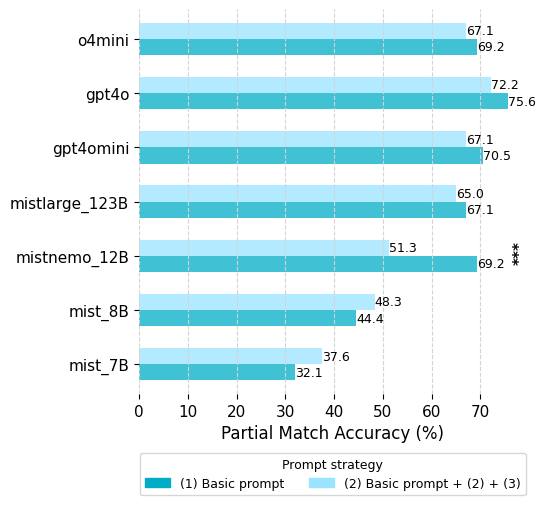

In [ ]:
plot_res=all_models_acc

# set figure size
plt.rcParams["figure.figsize"] = [5, 5]

# set color palette
cols=sns.color_palette(cc.glasbey, n_colors=40)

# create a mapping of rownames to colors
row_colors = dict(zip(plot_res.columns, [cols[3], cols[25]]))

# create bar plot
ax=plot_res.plot(kind='barh', color=row_colors, width=0.6, legend=False)

# add text
for bar in ax.patches:
    x = bar.get_width() # bar length (horizontal position)
    y = bar.get_y() + bar.get_height()/2 # center the bar (vertical position)
    ax.text(x+0.02, y, f'{x:.1f}', ha='left', va='center', fontsize=9)
    
# add p-value significance
yticks = np.arange(len(plot_res.index))  
bar_height = ax.patches[0].get_height()
n_bars = plot_res.shape[1] # bars per group (i.e., columns in plot_res)
bar_offsets = np.linspace(-bar_height/2, bar_height/2, n_bars, endpoint=False) # offsets per bar within group

for i, (label, pval) in enumerate(p_values.items()):
    if label not in plot_res.index:
        continue
    row_idx = plot_res.index.get_loc(label)

    # get the bars for this group
    bar_group = ax.patches[row_idx * n_bars : (row_idx + 1) * n_bars]
    if len(bar_group) < 2:
        continue

    bar1, bar2 = bar_group
    y_pos = yticks[row_idx] + np.mean(bar_offsets[:2]) + bar_height / 2

    # place to the right of the longer bar
    x_pos = max(bar1.get_width(), bar2.get_width()) + 1.0

    # convert p-value to stars
    sig = pval_to_stars(pval)
    if sig:
        ax.text(x_pos, y_pos, sig,
                ha='left', va='center',
                fontsize=11, fontweight='bold', rotation=90)

    
# x, y label and ticks
ax.set_xlabel('Partial Match Accuracy (%)', fontsize=12)
ax.set_ylabel('')
ax.tick_params(labelsize=11)
for spine in ax.spines.values():
    spine.set_visible(False)

# set alpha for the rest of the bars
for i, patch in enumerate(ax.patches):
    patch.set_alpha(0.75)

# create a custom legend
handles = [plt.Rectangle((0,0),1,1, color=row_colors[name]) for name in plot_res.columns]
legend = ax.legend(handles, plot_res.columns, 
          title="Prompt strategy", 
          bbox_to_anchor=(0.5, -0.12), ncol=2,
          borderaxespad=1,
          loc='upper center',
          fontsize=9,
          title_fontsize=9
          )
legend.get_frame().set_facecolor('white')

# set background and grid color
ax.set_facecolor('white')
ax.grid(axis='x', linestyle='--', color='lightgray', linewidth=0.8)

# save
save = True
if save == True:
    plt.savefig(f'./figures/Figure2_accuracyPromptLLMbar.jpeg', dpi=500, bbox_inches='tight')
plt.show()

#### Figure 3A. Impact of RAG integration on LLM performance with unstructured and structured database

In [114]:
# Load RAG-LLM and baseline results
base_model='gpt4o'
rag_unstruc_res_dict_0 = load_object(filename=os.path.join(root_dir, f'output/RAG_res_{base_model}/unstructured/RAGstra0n5temp0.0_res_dict.pkl'))
rag_struc_res_dict_0 = load_object(filename=os.path.join(root_dir, f'output/RAG_res_{base_model}/structured/RAGstra0n5temp0.0_res_dict.pkl'))
llm_res_dict_0 = load_object(filename=os.path.join(root_dir, f'output/LLM_res_{base_model}/stra0n5temp0.0_res_dict.pkl'))

In [115]:
# Evaluate RAG-LLM output from the first iteration
unstruc_results = calc_eval_metrics(rag_unstruc_res_dict_0['full output'][0], moalmanac_data['prompt'], synthetic_prompt_groundtruth_dict)
struc_results = calc_eval_metrics(rag_struc_res_dict_0['full output'][0], moalmanac_data['prompt'], synthetic_prompt_groundtruth_dict)
llm_results = calc_eval_metrics(llm_res_dict_0['full output'][0], moalmanac_data['prompt'], synthetic_prompt_groundtruth_dict)

print("-----First iteration-----")
print(f"Unstructured: {unstruc_results['avg_exact_match_acc']}, {unstruc_results['avg_partial_match_acc']}, {unstruc_results['avg_precision']}")
print(f"Structured: {struc_results['avg_exact_match_acc']}, {struc_results['avg_partial_match_acc']}, {struc_results['avg_precision']}")
print(f"LLM-only: {llm_results['avg_exact_match_acc']}, {llm_results['avg_partial_match_acc']}, {llm_results['avg_precision']}")

-----First iteration-----
Unstructured: 0.7948717948717948, 0.9017094017094017, 0.49424603174603166
Structured: 0.9444444444444444, 0.9529914529914529, 0.793091168091168
LLM-only: 0.6153846153846154, 0.7521367521367521, 0.44864672364672314


In [17]:
# Calculate evaluation metrics for the RAG-LLM output from all iterations
all_results_ls = {'unstructured':[], 'structured':[], 'llm':[]}
avg_exact_acc_ls = {'unstructured':[], 'structured':[], 'llm':[]}
avg_partial_acc_ls = {'unstructured':[], 'structured':[], 'llm':[]}
avg_precision_ls = {'unstructured':[], 'structured':[], 'llm':[]}
avg_recall_ls = {'unstructured':[], 'structured':[], 'llm':[]}
avg_f1_ls = {'unstructured':[], 'structured':[], 'llm':[]}
avg_specificity_ls = {'unstructured':[], 'structured':[], 'llm':[]}

for i in range(5):
    try:
        unstruc_results = calc_eval_metrics(rag_unstruc_res_dict_0['full output'][i], moalmanac_data['prompt'], synthetic_prompt_groundtruth_dict)
        struc_results = calc_eval_metrics(rag_struc_res_dict_0['full output'][i], moalmanac_data['prompt'], synthetic_prompt_groundtruth_dict)
        llm_results = calc_eval_metrics(llm_res_dict_0['full output'][i], moalmanac_data['prompt'], synthetic_prompt_groundtruth_dict)
        
        all_results_ls['unstructured'].append(unstruc_results)
        all_results_ls['structured'].append(struc_results) 
        all_results_ls['llm'].append(llm_results) 
        
        avg_exact_acc_ls['unstructured'].append(unstruc_results['avg_exact_match_acc'])
        avg_exact_acc_ls['structured'].append(struc_results['avg_exact_match_acc'])
        avg_exact_acc_ls['llm'].append(llm_results['avg_exact_match_acc'])
        
        avg_partial_acc_ls['unstructured'].append(unstruc_results['avg_partial_match_acc'])
        avg_partial_acc_ls['structured'].append(struc_results['avg_partial_match_acc'])
        avg_partial_acc_ls['llm'].append(llm_results['avg_partial_match_acc'])
        
        avg_precision_ls['unstructured'].append(unstruc_results['avg_precision'])
        avg_precision_ls['structured'].append(struc_results['avg_precision'])
        avg_precision_ls['llm'].append(llm_results['avg_precision'])
        
        avg_recall_ls['unstructured'].append(unstruc_results['avg_recall'])
        avg_recall_ls['structured'].append(struc_results['avg_recall'])
        avg_recall_ls['llm'].append(llm_results['avg_recall'])
        
        avg_f1_ls['unstructured'].append(unstruc_results['avg_f1'])
        avg_f1_ls['structured'].append(struc_results['avg_f1'])
        avg_f1_ls['llm'].append(llm_results['avg_f1'])
        
        avg_specificity_ls['unstructured'].append(unstruc_results['avg_specificity'])
        avg_specificity_ls['structured'].append(struc_results['avg_specificity'])
        avg_specificity_ls['llm'].append(llm_results['avg_specificity'])
        
    except Exception as e:
        print(e)
        continue

In [26]:
print("Average exact acc:",{key: np.mean(value) for key, value in avg_exact_acc_ls.items()})
print("Average partial acc:",{key: np.mean(value) for key, value in avg_partial_acc_ls.items()})
print("Average precision:",{key: np.mean(value) for key, value in avg_precision_ls.items()})
print("Average recall:",{key: np.mean(value) for key, value in avg_recall_ls.items()})
print("Average f1:",{key: np.mean(value) for key, value in avg_f1_ls.items()})
print("Average specificity:",{key: np.mean(value) for key, value in avg_specificity_ls.items()})

Average exact acc: {'unstructured': 0.7931623931623932, 'structured': 0.941025641025641, 'llm': 0.6170940170940171}
Average partial acc: {'unstructured': 0.9076923076923077, 'structured': 0.9529914529914529, 'llm': 0.7538461538461538}
Average precision: {'unstructured': 0.4916625966625965, 'structured': 0.7969210419210417, 'llm': 0.4379059829059824}
Average recall: {'unstructured': 0.8535612535612538, 'structured': 0.947008547008547, 'llm': 0.7058404558404553}
Average f1: {'unstructured': 0.5715557851455293, 'structured': 0.8427215804138882, 'llm': 0.5087986087986094}
Average specificity: {'unstructured': 0.9658298602884694, 'structured': 0.9916636892004626, 'llm': 0.9759272458748841}


##### Run statistical test to compare performances

RAG-LLM unstructured vs. LLM-only - across five iterations - mcnemar's test

In [27]:
# Create contingency table
exact_table_ls=[]
partial_table_ls=[]
model_A='unstructured'
model_B='llm'

for i in range(5):
    exact_table_ls.append(create_mcnemar_table(
        all_results_ls[model_A][i]['exact_match_acc'], 
        all_results_ls[model_B][i]['exact_match_acc'] 
        )
                          )
    
    partial_table_ls.append(create_mcnemar_table(
        all_results_ls[model_A][i]['partial_match_acc'], 
        all_results_ls[model_B][i]['partial_match_acc']
        )
                            )

In [31]:
exact_result_ls=[]
partial_result_ls=[]
exact_result_pval=[]
partial_result_pval=[]
exact_result_bc=[]
partial_result_bc=[]
pooled_exact = np.array([[0, 0], [0, 0]])
pooled_partial = np.array([[0, 0], [0, 0]])

for i in range(5):
    # run mcnemar's test separately
    exact_result, exact_bc = conduct_mcnemar_test(exact_table_ls[i])
    partial_result, partial_bc = conduct_mcnemar_test(partial_table_ls[i])
    exact_result_ls.append(exact_result)
    partial_result_ls.append(partial_result)
    
    # pool matrix
    pooled_exact += np.array(exact_table_ls[i])
    pooled_partial += np.array(partial_table_ls[i])

    # mcnemar's p-values
    exact_result_pval.append(exact_result.pvalue)
    partial_result_pval.append(partial_result.pvalue)
    
    # get discordant (b,c) values (if b > c, model A is better)
    exact_result_bc.append(exact_bc)
    partial_result_bc.append(partial_bc)

# run mcnemar's test on pooled matrix
pooled_exact_result, pooled_exact_bc = conduct_mcnemar_test(pooled_exact) 
pooled_partial_result, pooled_partial_bc = conduct_mcnemar_test(pooled_partial)

print(f'{model_A}_vs_{model_B}:')
print(f'Exact: {print_mcnemar_res(pooled_exact_result, alpha=0.05)}')
print(f'Partial: {print_mcnemar_res(pooled_partial_result, alpha=0.05)}')

all_mcnemar_results = {
    f'{model_A}_vs_{model_B}': {'exact': pooled_exact_result, 'partial': pooled_partial_result}
    }

unstructured_vs_llm:
Exact: Significance: True; Test Statistic: 153.37591240875912; P-value: 3.170431977463823e-35
Partial: Significance: True; Test Statistic: 129.19758064516128; P-value: 6.1392583682076796e-30


RAG-LLM structured vs. RAG-LLM unstructured - across five iterations - mcnemar's test

In [32]:
# Create contingency table
exact_table_ls=[]
partial_table_ls=[]
model_A='structured'
model_B='unstructured'

for i in range(5):
    exact_table_ls.append(create_mcnemar_table(
        all_results_ls[model_A][i]['exact_match_acc'], 
        all_results_ls[model_B][i]['exact_match_acc'] 
        )
                          )
    
    partial_table_ls.append(create_mcnemar_table(
        all_results_ls[model_A][i]['partial_match_acc'], 
        all_results_ls[model_B][i]['partial_match_acc']
        )
                            )

In [33]:
exact_result_ls=[]
partial_result_ls=[]
exact_result_pval=[]
partial_result_pval=[]
exact_result_bc=[]
partial_result_bc=[]
pooled_exact = np.array([[0, 0], [0, 0]])
pooled_partial = np.array([[0, 0], [0, 0]])

for i in range(5):
    # run mcnemar's test separately
    exact_result, exact_bc = conduct_mcnemar_test(exact_table_ls[i])
    partial_result, partial_bc = conduct_mcnemar_test(partial_table_ls[i])
    exact_result_ls.append(exact_result)
    partial_result_ls.append(partial_result)
    
    # pool matrix
    pooled_exact += np.array(exact_table_ls[i])
    pooled_partial += np.array(partial_table_ls[i])

    # mcnemar's p-values
    exact_result_pval.append(exact_result.pvalue)
    partial_result_pval.append(partial_result.pvalue)
    
    # get discordant (b,c) values (if b > c, model A is better)
    exact_result_bc.append(exact_bc)
    partial_result_bc.append(partial_bc)

# run mcnemar's test on pooled matrix
pooled_exact_result, pooled_exact_bc = conduct_mcnemar_test(pooled_exact) 
pooled_partial_result, pooled_partial_bc = conduct_mcnemar_test(pooled_partial)

print(f'{model_A}_vs_{model_B}:')
print(f'Exact: {print_mcnemar_res(pooled_exact_result, alpha=0.05)}')
print(f'Partial: {print_mcnemar_res(pooled_partial_result, alpha=0.05)}')

all_mcnemar_results[f'{model_A}_vs_{model_B}'] = {
    'exact': pooled_exact_result, 'partial': pooled_partial_result
    }

structured_vs_unstructured:
Exact: Significance: True; Test Statistic: 103.80350877192983; P-value: 2.23409161233704e-24
Partial: Significance: True; Test Statistic: 16.588957055214724; P-value: 4.642052747520578e-05


##### Adjust p-values from all comparisons

In [34]:
all_pvalues=[]
for comparison, output in all_mcnemar_results.items():
    all_pvalues.append(output['exact'].pvalue)
    all_pvalues.append(output['partial'].pvalue)
all_pvalues

[3.170431977463823e-35,
 6.1392583682076796e-30,
 2.23409161233704e-24,
 4.642052747520578e-05]

In [35]:
# multiple test correction
_, p_corrected, _, _ = multipletests(all_pvalues, alpha=0.05, method='fdr_bh')
p_corrected

array([1.26817279e-34, 1.22785167e-29, 2.97878882e-24, 4.64205275e-05])

In [43]:
print(f"Raw: {all_mcnemar_results['unstructured_vs_llm']['exact'].pvalue}, {all_mcnemar_results['unstructured_vs_llm']['partial'].pvalue}")
print(f'Adjusted: {p_corrected[0:2]}')

Raw: 3.170431977463823e-35, 6.1392583682076796e-30
Adjusted: [1.26817279e-34 1.22785167e-29]


In [44]:
print(f"Raw: {all_mcnemar_results['structured_vs_unstructured']['exact'].pvalue}, {all_mcnemar_results['structured_vs_unstructured']['partial'].pvalue}")
print(f'Adjusted: {p_corrected[2:4]}')

Raw: 2.23409161233704e-24, 4.642052747520578e-05
Adjusted: [2.97878882e-24 4.64205275e-05]


##### Plot bar graph

Using acc results from all five iterations

In [45]:
# compute means and standard deviations
means = {
    'LLM-only': 
        [np.mean(avg_exact_acc_ls['llm']) * 100, np.mean(avg_partial_acc_ls['llm']) * 100],
    'Unstructured RAG-LLM': 
        [np.mean(avg_exact_acc_ls['unstructured']) * 100, np.mean(avg_partial_acc_ls['unstructured']) * 100],
    'Structured RAG-LLM': 
        [np.mean(avg_exact_acc_ls['structured']) * 100, np.mean(avg_partial_acc_ls['structured']) * 100]
        }

stds = {
    'LLM-only': 
        [np.std(avg_exact_acc_ls['llm']) * 100, np.std(avg_partial_acc_ls['llm']) * 100],
    'Unstructured RAG-LLM': 
        [np.std(avg_exact_acc_ls['unstructured']) * 100, np.std(avg_partial_acc_ls['unstructured']) * 100],
    'Structured RAG-LLM': 
        [np.std(avg_exact_acc_ls['structured']) * 100, np.std(avg_partial_acc_ls['structured']) * 100]
        }


# convert to dataframe
plot_res = pd.DataFrame(means, index=['Exact match accuracy','Partial match accuracy'])

# Convert stds to DataFrame for error bars
error_bars = pd.DataFrame(stds, index=['Exact match accuracy','Partial match accuracy'])

plot_res

,LLM-only,Unstructured RAG-LLM,Structured RAG-LLM
Exact match accuracy,61.709402,79.316239,94.102564
Partial match accuracy,75.384615,90.769231,95.299145


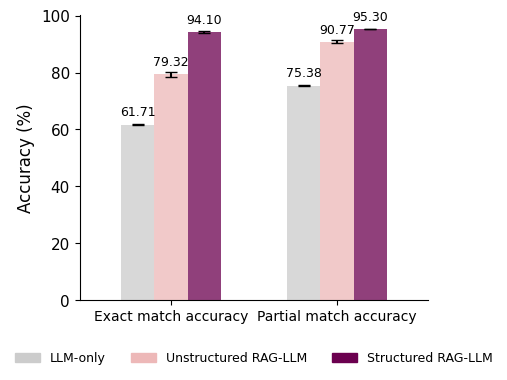

In [46]:
# set figure size
plt.rcParams["figure.figsize"] = [4.5, 3.7]

# set color palette
cols=sns.color_palette(cc.glasbey, n_colors=40)

# create a mapping of rownames to colors
row_colors = dict(zip(plot_res.columns, ['0.8', cols[23], cols[6]]))

# create bar plot
ax=plot_res.plot(
    kind='bar', 
    yerr=error_bars,
    capsize=4,
    color=[row_colors[name] for name in plot_res.columns], 
    width=0.6, 
    legend=False
    )

# add text
for bar in ax.patches:
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    ax.text(x, y+2, f'{y:.2f}', ha='center', va='bottom', fontsize=9)
    
# x, y labels, ticks, grid
ax.set_xlabel('')
ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.tick_params(axis='x', labelsize=10, rotation=0)
ax.tick_params(axis='y', labelsize=11)
ax.set_facecolor(color='white')

# borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
    
# set alpha for the rest of the bars
for i, patch in enumerate(ax.patches):
    patch.set_alpha(0.75)

# create a custom legend
handles = [plt.Rectangle((0,0),1,1, color=row_colors[name]) for name in plot_res.columns]
legend = ax.legend(handles, plot_res.columns, 
          title=False, 
          bbox_to_anchor=(0.5, -0.12), ncol=3,
          frameon=False,
          borderaxespad=1,
          loc='upper center',
          fontsize=9,
          title_fontsize=9
          ) 
legend.get_frame().set_facecolor('white')

# save
save = False
if save == True:
    plt.savefig(f'./figures/{base_model}/Figure3_accuracyRAGLLMbar.jpeg', dpi=500, bbox_inches='tight')

plt.show()

#### Figure 3B. Impact on other evaluation metrics: precision, recall, f1, specificity

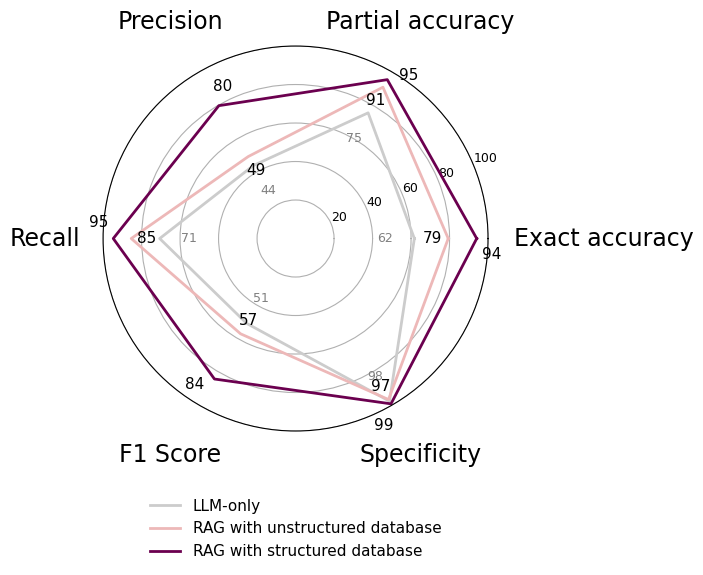

In [47]:
from math import pi
import matplotlib.pyplot as plt

# color palette
cols=sns.color_palette(cc.glasbey, n_colors=40)

# metrics
metrics = ['Exact accuracy', 'Partial accuracy', 'Precision', 'Recall', 'F1 Score', 'Specificity']

# llm-only model (averaged across five runs)
values_llm = [
    np.mean(avg_exact_acc_ls['llm']),
    np.mean(avg_partial_acc_ls['llm']),
    np.mean(avg_precision_ls['llm']),
    np.mean(avg_recall_ls['llm']),
    np.mean(avg_f1_ls['llm']),
    np.mean(avg_specificity_ls['llm'])
    ]
values_llm = [value*100 for value in values_llm] 
values_llm += values_llm[:1] 

# unstructured model (averaged across five runs)
values_unstruc = [
    np.mean(avg_exact_acc_ls['unstructured']),
    np.mean(avg_partial_acc_ls['unstructured']),
    np.mean(avg_precision_ls['unstructured']),
    np.mean(avg_recall_ls['unstructured']),
    np.mean(avg_f1_ls['unstructured']),
    np.mean(avg_specificity_ls['unstructured'])
    ]
values_unstruc = [value*100 for value in values_unstruc] 
values_unstruc += values_unstruc[:1] 

# structured model (averaged across five runs)
values_struc = [
    np.mean(avg_exact_acc_ls['structured']),
    np.mean(avg_partial_acc_ls['structured']),
    np.mean(avg_precision_ls['structured']),
    np.mean(avg_recall_ls['structured']),
    np.mean(avg_f1_ls['structured']),
    np.mean(avg_specificity_ls['structured'])
    ]
values_struc = [value*100 for value in values_struc] 
values_struc += values_struc[:1]

# radar chart setup
angles = [n / float(len(metrics)) * 2 * pi for n in range(len(metrics))]
angles += angles[:1]

# set up the plot
plt.figure(figsize=(5, 5))
ax = plt.subplot(111, polar=True)

# plot the models
ax.plot(angles, values_llm, color='0.8', linewidth=2, linestyle='solid', 
        label='LLM-only')
ax.plot(angles, values_unstruc, color=cols[23], linewidth=2, linestyle='solid',
        label='RAG with unstructured database')
ax.plot(angles, values_struc, color=cols[6], linewidth=2, linestyle='solid', 
        label='RAG with structured database')

# Annotate each metric value
for i in range(len(metrics)):
    ax.text(angles[i], values_llm[i] - 15, 
            f"{values_llm[i]:.0f}",
            color='grey', fontsize=9, ha='center', va='center')
    ax.text(angles[i], values_unstruc[i] - 8, 
            f"{values_unstruc[i]:.0f}",
            color='black', fontsize=11, ha='center', va='center')
    ax.text(angles[i] - 0.08, values_struc[i] + 8, 
            f"{values_struc[i]:.0f}",
            color='black', fontsize=11, ha='center', va='center')

# Labels and ticks
ax.set_ylim(0, 100)
ax.tick_params(axis='y', labelsize=9)
ax.set_xticks([])
for i, metric in enumerate(metrics): # Manually set the position of the labels outside the chart
    angle = angles[i]  
    if angle == 0:  
        ax.text(angle, 160, metric, horizontalalignment='center', verticalalignment='center', fontsize=17)       
    else:
        ax.text(angle, 130, metric, horizontalalignment='center', verticalalignment='center', fontsize=17)       

# Create a custom legend
from matplotlib.lines import Line2D
handles = [Line2D([0], [0], color=col, linewidth=2) for col in ['0.8', cols[23], cols[6]]]
legend = ax.legend(handles, ['LLM-only', 'RAG with unstructured database', 'RAG with structured database'], 
          title=False, 
          bbox_to_anchor=(0.5, -0.12), ncol=1,
          frameon=False,
          borderaxespad=1,
          loc='upper center',
          fontsize=11
          ) 
legend.get_frame().set_facecolor('white')

# Save plot
save = False
if save == True:
    plt.savefig(f'./figures/{base_model}/Figure3_ragllmPerformance_radar.jpeg', dpi=600, bbox_inches='tight')

plt.show()

In [ ]:
# Calculate percent increase of evaluation metrics
def perc_increase(old, new):
    if old == 0:
        if new == 0:
            return 0  
        return None  
    return ((new - old) / old) * 100

perc_increase_ls=[]
for i in range(len(values_unstruc)):
    perc_increase_ls.append(perc_increase(new=values_struc[i], old=values_unstruc[i]))

print(dict(zip(['exact_match_acc', 'partial_match_acc','avg_precision','avg_recall','avg_f1','avg_specificity'], perc_increase_ls)))
print(f'Precision: {values_unstruc[2]:.2f} to {values_struc[2]:.2f}')
print(f'F1-score: {values_unstruc[4]:.2f} to {values_struc[4]:.2f}')

{'exact_match_acc': 18.642241379310338, 'partial_match_acc': 4.990583804143116, 'avg_precision': 62.08697739680385, 'avg_recall': 10.947930574098763, 'avg_f1': 47.44345212065604, 'avg_specificity': 2.674780515097881}
Precision: 49.17 to 79.69
F1-score: 57.16 to 84.27


In [54]:
# Compare statistically
from scipy.stats import wilcoxon, ttest_rel

print(wilcoxon(avg_precision_ls['structured'], avg_precision_ls['unstructured'], alternative='greater'))
print(wilcoxon(avg_recall_ls['structured'], avg_recall_ls['unstructured'], alternative='greater'))
print(wilcoxon(avg_f1_ls['structured'], avg_f1_ls['unstructured'], alternative='greater'))
print(wilcoxon(avg_specificity_ls['structured'], avg_specificity_ls['unstructured'], alternative='greater'))

WilcoxonResult(statistic=15.0, pvalue=0.03125)
WilcoxonResult(statistic=15.0, pvalue=0.03125)
WilcoxonResult(statistic=15.0, pvalue=0.03125)
WilcoxonResult(statistic=15.0, pvalue=0.03125)


#### Figure 3C. Accuracy of RAG-LLM across therapies, diseases and genomic alterations

Get exact match accuracies from the first iteration

In [55]:
# Create df for plotting
plot_df = moalmanac_data
plot_df['RAGLLM_struc_res'] = struc_results['exact_match_acc']
plot_df['RAGLLM_unstruc_res'] = unstruc_results['exact_match_acc']
plot_df['oncotree_code'] = plot_df['oncotree_code'].fillna('Any solid tumor')

Accuracy across cancer types

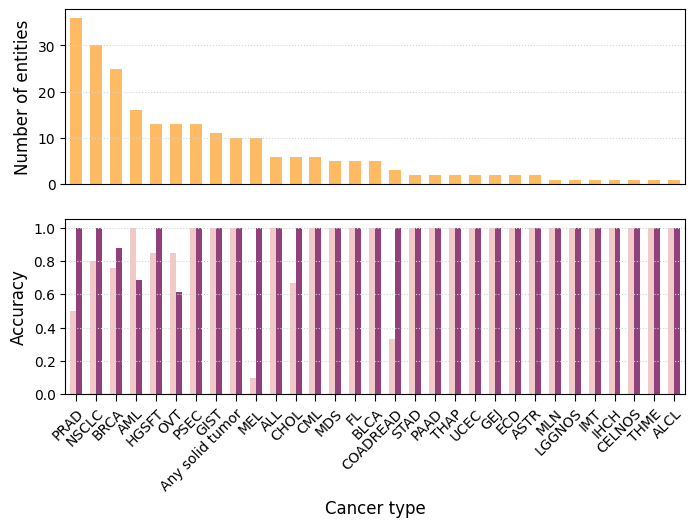

In [56]:
# set figure subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8,5), gridspec_kw=dict(height_ratios=[1, 1]))

# set color palette
cols=sns.color_palette(cc.glasbey, n_colors=40)

# create accuracy dataframe 
df_all = pd.DataFrame()
for col in ['RAGLLM_unstruc_res', 'RAGLLM_struc_res']:
    df = pd.crosstab(plot_df['oncotree_code'], plot_df[col])
    df['accuracy'] = df[True] / (df[True] + df[False])
    df_all = pd.concat([df_all, df.rename(columns = {'accuracy':col})[col]], axis = 1)

# add counts (number of relationships)
group_cnt_df = pd.DataFrame.from_dict(Counter(plot_df['oncotree_code']), orient="index", columns=["Number of relationships"])
df_all=df_all.merge(group_cnt_df, left_index=True, right_index=True)

# sort by number of relationships (descending) 
df_all = df_all.sort_values(by="Number of relationships", ascending=False)

# create a mapping of names to colors
struc_unstruc_colors = dict(zip(df_all.columns[0:2], [cols[23],cols[6]]))
num_rel_color = cols[7]

# create bar plot
df_all[['RAGLLM_unstruc_res', 'RAGLLM_struc_res']].plot(kind='bar', color=struc_unstruc_colors, 
                                                        width=0.6, legend=False, ax=axes[1])
df_all['Number of relationships'].plot(kind='bar', color=num_rel_color, width=0.6, legend=False, ax=axes[0])
    
# x, y label and ticks
axes[0].set_ylabel('Number of entities', fontsize=12)
axes[0].set_xticks([])
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_xlabel('Cancer type', fontsize=12)
axes[1].tick_params(axis='x', labelrotation=45, size=5)
for label in axes[1].get_xticklabels():
    label.set_ha('right') 
    label.set_rotation_mode('anchor')

# set alpha for the rest of the bars
for i, patch in enumerate(axes[0].patches):
    patch.set_alpha(0.75)

for i, patch in enumerate(axes[1].patches):
    patch.set_alpha(0.75)

# change background and grid color
for ax in axes:
    # change background color
    ax.set_facecolor('white')
    # change grid color
    ax.grid(visible=True, axis='y', color='lightgray', linestyle='dotted')  

# Save plot
save = False
if save == True:
    plt.savefig(f'./figures/{base_model}/Figure3_cancerAcc_heatmap.jpeg', dpi=600, bbox_inches='tight')
plt.show()

In [57]:
# calculate percentage increase
df_all['perc_increase'] = df_all.apply(lambda row: perc_increase(old=row['RAGLLM_unstruc_res'], 
                                                                 new=row['RAGLLM_struc_res']), 
                                       axis=1)

df_all_perc=df_all.sort_values(by="perc_increase", ascending=False)

# top cancer types with percentage increase >= 30 and number of relationships >= 5
df_all_perc.loc[(df_all_perc['perc_increase'] >= 30) & (df_all_perc['Number of relationships'] >= 5), :]\
    .merge(plot_df[['oncotree_term','oncotree_code']], 
           left_index=True, right_on='oncotree_code', how='inner')\
               .drop_duplicates()

,RAGLLM_unstruc_res,RAGLLM_struc_res,Number of relationships,perc_increase,oncotree_term,oncotree_code
30,0.100000,1.0,10,900.0,Melanoma,MEL
28,0.500000,1.0,36,100.0,Prostate Adenocarcinoma,PRAD
10,0.666667,1.0,6,50.0,Cholangiocarcinoma,CHOL


Accuracy across therapy types

In [58]:
# clean therapy strategy names
plot_df['therapy_strategy_2']=plot_df['therapy_strategy'].replace(r'inhibition|targets|signaling','', regex=True).str.replace(r'\s+', ' ', regex=True).replace(r'chemotherapy|Chemotherapy','chemo', regex=True).str.strip()

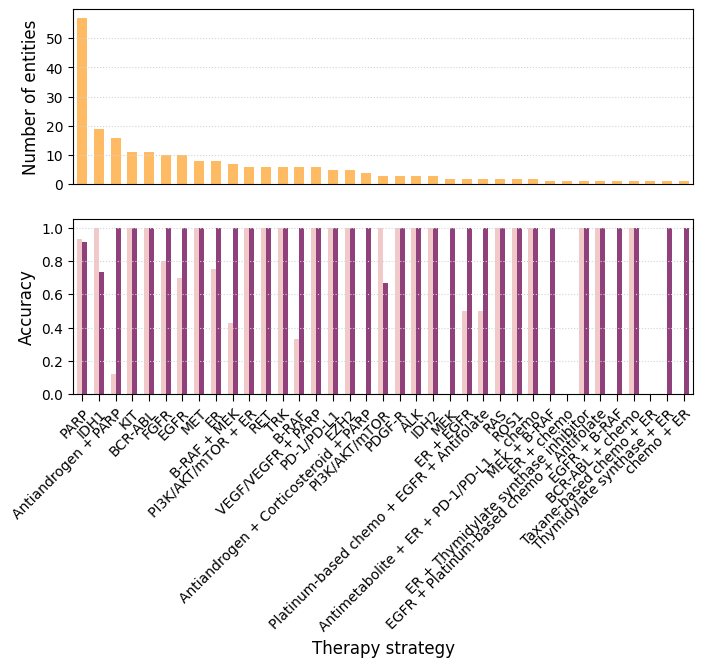

In [59]:
# set figure subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8,5), gridspec_kw=dict(height_ratios=[1, 1]))

# set color palette
cols=sns.color_palette(cc.glasbey, n_colors=40)

# create accuracy dataframe 
df_all = pd.DataFrame()
for col in ['RAGLLM_unstruc_res', 'RAGLLM_struc_res']:
    df = pd.crosstab(plot_df['therapy_strategy_2'], plot_df[col])
    df['accuracy'] = df[True] / (df[True] + df[False])
    df_all = pd.concat([df_all, df.rename(columns = {'accuracy':col})[col]], axis = 1)

# add counts (number of relationships)
group_cnt_df = pd.DataFrame.from_dict(Counter(plot_df['therapy_strategy_2']), orient="index", columns=["Number of relationships"])
df_all = df_all.merge(group_cnt_df, left_index=True, right_index=True)

# sort by number of relationships (descending) 
df_all = df_all.sort_values(by="Number of relationships", ascending=False)

# create a mapping of names to colors
struc_unstruc_colors = dict(zip(df_all.columns[0:2], [cols[23],cols[6]]))
num_rel_color = cols[7]

# create bar plot
df_all[['RAGLLM_unstruc_res', 'RAGLLM_struc_res']].plot(kind='bar', color=struc_unstruc_colors, width=0.6, legend=False, ax=axes[1])
df_all['Number of relationships'].plot(kind='bar', color=num_rel_color, width=0.6, legend=False, ax=axes[0])
    
# x, y label and ticks
axes[0].set_ylabel('Number of entities', fontsize=12)
axes[0].set_xticks([])
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_xlabel('Therapy strategy', fontsize=12)
axes[1].tick_params(axis='x', labelrotation=45, size=5)
for label in axes[1].get_xticklabels():
    label.set_ha('right') 
    label.set_rotation_mode('anchor') 

# set alpha for the rest of the bars
for i, patch in enumerate(axes[0].patches):
    patch.set_alpha(0.75)

for i, patch in enumerate(axes[1].patches):
    patch.set_alpha(0.75)

# change background and grid color
for ax in axes:
    # change background color
    ax.set_facecolor('white')
    # change grid color
    ax.grid(visible=True, axis='y', color='lightgray', linestyle='dotted')

# save plot
save = False
if save == True:
    plt.savefig(f'./figures/{base_model}/Figure3_therapyAcc_heatmap.jpeg', dpi=600, bbox_inches='tight')
plt.show()

In [60]:
# calculate percentage increase dataframe
df_all['perc_increase'] = df_all.apply(lambda row: perc_increase(old=row['RAGLLM_unstruc_res'], 
                                                                 new=row['RAGLLM_struc_res']), 
                                       axis=1)

df_all_perc=df_all.sort_values(by="perc_increase", ascending=False)

# top cancer types with percentage increase >= 30 and number of relationships >= 5
df_all_perc.loc[(df_all_perc['perc_increase'] >= 30) & (df_all_perc['Number of relationships'] >= 5), :]

,RAGLLM_unstruc_res,RAGLLM_struc_res,Number of relationships,perc_increase
Antiandrogen + PARP,0.125000,1.0,16,700.000000
B-RAF,0.333333,1.0,6,200.000000
B-RAF + MEK,0.428571,1.0,7,133.333333
EGFR,0.700000,1.0,10,42.857143
ER,0.750000,1.0,8,33.333333


In [61]:
df_all_perc.loc[(df_all_perc['perc_increase'] >= 30) & (df_all_perc['Number of relationships'] >= 5), :].index

Index(['Antiandrogen + PARP', 'B-RAF', 'B-RAF + MEK', 'EGFR', 'ER'], dtype='object')

Accuracy from a subgroup of questions

In [62]:
def avg_acc_over_questions(results_dict, question_ind):
    
    exact_acc = np.mean([
        np.mean([results_dict[run]['exact_match_acc'][q] for q in question_ind])
        for run in range(len(results_dict))
        ])
    
    partial_acc = np.mean([
        np.mean([results_dict[run]['partial_match_acc'][q] for q in question_ind])
        for run in range(len(results_dict))
        ])
    
    return f"avg exact acc={exact_acc*100:.2f}; avg partial acc={partial_acc*100:.2f}"

In [63]:
ar_parp_ind = [i for i in range(len(moalmanac_data)) if moalmanac_data.loc[i, 'therapy_strategy'] == 'Antiandrogen + PARP inhibition']

print('LLM-only: '+avg_acc_over_questions(all_results_ls['llm'], question_ind=ar_parp_ind))
print('Unstructured: '+avg_acc_over_questions(all_results_ls['unstructured'], question_ind=ar_parp_ind))
print('Structured: '+avg_acc_over_questions(all_results_ls['structured'], question_ind=ar_parp_ind))

LLM-only: avg exact acc=0.00; avg partial acc=0.00
Unstructured: avg exact acc=11.25; avg partial acc=48.75
Structured: avg exact acc=100.00; avg partial acc=100.00


#### Figure 4A-B. RAG-LLM performance on real-world questions

In [64]:
real_questions = pd.read_csv(os.path.join(root_dir, 'data/real_world_queries.csv'), index_col=0)

In [65]:
# Load LLM outputs from real-world queries (gpt4o) 
base_model = 'gpt4o'
real_rag_res_dict_4 = load_object(filename=os.path.join(root_dir, f'output/RAG_res_{base_model}/realworld/RAGstra4n5temp0.0_res_dict.pkl'))
real_rag_res_dict_5 = load_object(filename=os.path.join(root_dir, f'output/RAG_res_{base_model}/realworld/RAGstra5n5temp0.0_res_dict.pkl'))

#### Label results from real-world queries

In [66]:
# Load mapping between real-world queries and ground-truth drugs
real_prompt_groundtruth_dict=load_object(os.path.join(root_dir, 'data/real_prompt_groundtruth_dict.pkl'))

In [67]:
# Load results from all runs
all_real_results = {
    4: {'ragllm_input':[],'ragllm_output':[],'full':[], 'partial':[], 'exact':[], 'avg_partial':[], 'avg_exact':[]},
    5: {'ragllm_input':[],'ragllm_output':[],'full':[], 'partial':[], 'exact':[], 'avg_partial':[], 'avg_exact':[]}
}

for i in range(len(real_rag_res_dict_4['full output'])):
    for strategy, output_dict in zip(
        [4, 5],
        [real_rag_res_dict_4, real_rag_res_dict_5]
    ):
        res = calc_eval_metrics(output_dict['full output'][i], real_questions['prompt'], real_prompt_groundtruth_dict)
        all_real_results[strategy]['ragllm_input'].append(output_dict['input prompt'][i])
        all_real_results[strategy]['ragllm_output'].append(output_dict['full output'][i])
        all_real_results[strategy]['full'].append(res)
        all_real_results[strategy]['partial'].append(res['partial_match_acc'])
        all_real_results[strategy]['exact'].append(res['exact_match_acc'])
        all_real_results[strategy]['avg_partial'].append(res['avg_partial_match_acc'])
        all_real_results[strategy]['avg_exact'].append(res['avg_exact_match_acc'])

def make_eval_df(data, prefix):
    return pd.DataFrame(data).T.add_prefix(prefix)

real_res_stra4_partial_acc_df = make_eval_df(all_real_results[4]['partial'], 'partial_match_acc_')
real_res_stra4_exact_acc_df   = make_eval_df(all_real_results[4]['exact'],   'exact_match_acc_')

real_res_stra5_partial_acc_df = make_eval_df(all_real_results[5]['partial'], 'partial_match_acc_')
real_res_stra5_exact_acc_df   = make_eval_df(all_real_results[5]['exact'],   'exact_match_acc_')


In [68]:
def calc_cnt_by_categories(strategy, results_dict, nth_iter, real_questions):

    matching_cnt_ls=[]
    missing_cnt_ls=[]
    hallucinating_cnt_ls=[]
    no_output_cnt_ls=[]
    
    all_true_set_of_subsets=results_dict[strategy]['full'][nth_iter]['true_drugs_generic_set_ls']
    all_pred_set_of_subsets=results_dict[strategy]['full'][nth_iter]['pred_drugs_generic_set_ls']

    for i in range(len(real_questions)):
        true_set_of_subsets = all_true_set_of_subsets[i]
        pred_set_of_subsets = all_pred_set_of_subsets[i]

        matching_cnt=len(pred_set_of_subsets.intersection(true_set_of_subsets))
        missing_cnt=len(true_set_of_subsets - pred_set_of_subsets)
        hallucinating_cnt=len(pred_set_of_subsets - true_set_of_subsets)
        no_output_cnt=1 if len(pred_set_of_subsets) == 0 else 0

        matching_cnt_ls.append(matching_cnt)
        missing_cnt_ls.append(missing_cnt)
        hallucinating_cnt_ls.append(hallucinating_cnt)
        no_output_cnt_ls.append(no_output_cnt)

    res_df=pd.DataFrame({
        'matching_cnt':matching_cnt_ls,
        'missing_cnt':missing_cnt_ls,
        'hallucinating_cnt':hallucinating_cnt_ls,
        'no_output_cnt':no_output_cnt_ls
        })
    
    res_df=pd.concat([real_questions, res_df], axis=1)

    return(res_df)

real_rag_res_cnt_df_4 = calc_cnt_by_categories(
    strategy=4, 
    results_dict=all_real_results, 
    nth_iter=0, 
    real_questions=real_questions)

real_rag_res_cnt_df_5 = calc_cnt_by_categories(
    strategy=5, 
    results_dict=all_real_results, 
    nth_iter=0, 
    real_questions=real_questions)

#### Figure 4A. Accuracies of RAG-LLM based on structured data on real-world questions

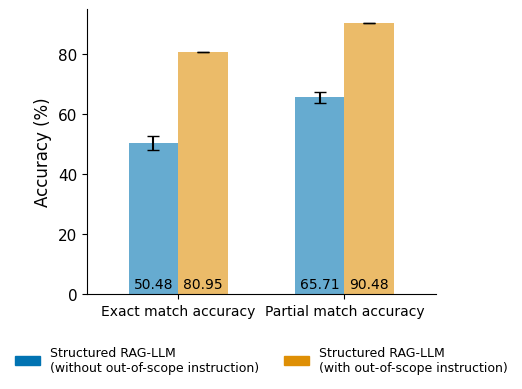

In [71]:
# compute means and standard deviations
means = {
    'Structured RAG-LLM \n(without out-of-scope instruction)': 
        [np.mean(all_real_results[4]['avg_exact']) * 100, np.mean(all_real_results[4]['avg_partial']) * 100],
    'Structured RAG-LLM \n(with out-of-scope instruction)': 
        [np.mean(all_real_results[5]['avg_exact']) * 100, np.mean(all_real_results[5]['avg_partial']) * 100]
}

stds = {
    'Structured RAG-LLM \n(without out-of-scope instruction)': 
        [np.std(all_real_results[4]['avg_exact']) * 100, np.std(all_real_results[4]['avg_partial']) * 100],
    'Structured RAG-LLM \n(with out-of-scope instruction)': 
        [np.std(all_real_results[5]['avg_exact']) * 100, np.std(all_real_results[5]['avg_partial']) * 100]
}

# convert to dataframe
plot_res = pd.DataFrame(means, index=['Exact match accuracy','Partial match accuracy'])

# Convert stds to DataFrame for error bars
error_bars = pd.DataFrame(stds, index=['Exact match accuracy','Partial match accuracy'])

# set figure size
plt.rcParams["figure.figsize"] = [4.5, 3.7]

# set color palette
cb_palette = sns.color_palette("colorblind")

# create a mapping of rownames to colors
row_colors = dict(zip(plot_res.columns, [cb_palette[0], cb_palette[1]]))

# create bar plot
ax=plot_res.plot(kind='bar', 
                 yerr=error_bars,
                 capsize=4,
                 color=[row_colors[name] for name in plot_res.columns], 
                 width=0.6, 
                 legend=False
                 )

# add text
for bar in ax.patches:
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    ax.text(x, 1, f'{y:.2f}', ha='center', va='bottom', fontsize=10, color='black')
    
# x, y labels, ticks, grid
ax.set_xlabel('')
ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.tick_params(axis='x', labelsize=10, rotation=0)
ax.tick_params(axis='y', labelsize=11)
ax.set_facecolor(color='white')

# borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
    
# set alpha for the rest of the bars
for i, patch in enumerate(ax.patches):
    patch.set_alpha(0.6)

# Create a custom legend
handles = [plt.Rectangle((0,0),1,1, color=row_colors[name]) for name in plot_res.columns]
legend = ax.legend(handles, plot_res.columns, 
          title=False, 
          bbox_to_anchor=(0.5, -0.12), ncol=2,
          frameon=False,
          borderaxespad=1,
          loc='upper center',
          fontsize=9,
          title_fontsize=9
          ) 
legend.get_frame().set_facecolor('white')

# save
save = False
if save == True:
    plt.savefig(f'./figures/{base_model}/Figure4_realworld_accuracyRAGLLMbar.jpeg', dpi=500, bbox_inches='tight')
plt.show()

#### Figure 4B-C. Stacked bar plot of RAG-LLM drug outputs from real-world questions

The result from the first iteration was used for the calculation of matching, missing, hallucinating, and no output counts.

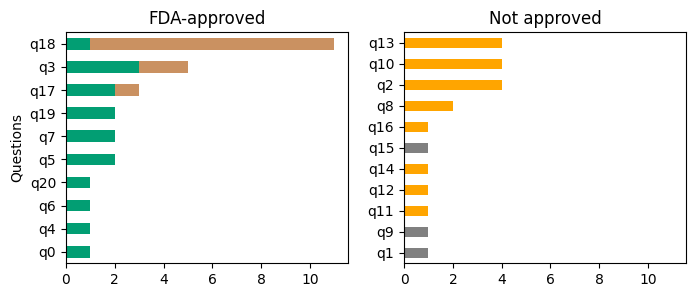

In [74]:
# convert to DataFrame
df = pd.DataFrame(real_rag_res_cnt_df_4
[['Question_index','Is_there_an_approval','matching_cnt','missing_cnt','hallucinating_cnt','no_output_cnt']])

# add a 'Total' column to sort by
df['total'] = df['matching_cnt'] + df['missing_cnt'] + df['hallucinating_cnt'] + df['no_output_cnt']

# sort by the 'Total' column
df_sorted = df.sort_values(['Is_there_an_approval','total'], ascending=[True, True])

# split into groups
df_true = df[df['Is_there_an_approval'] == True].sort_values('total', ascending=True)
df_false = df[df['Is_there_an_approval'] == False].sort_values('total', ascending=True)

# create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 3), sharex=True)

# set colors
cb_palette = sns.color_palette("colorblind")
colors = [cb_palette[2], cb_palette[5], "orange", "grey"]

# count columns to plot
plot_cnt = ['matching_cnt', 'missing_cnt', 'hallucinating_cnt', 'no_output_cnt']

# set axes background color
ax.set_facecolor('white') 

# plot each facet
for ax, subdf, title in zip(axes, [df_true, df_false], ['FDA-approved', 'Not approved']):
    subdf.set_index("Question_index")[plot_cnt]\
        .plot(kind="barh", stacked=True, color=colors, ax=ax, edgecolor=None, legend=False)
    
    ax.set_title(title)
    # ax.set_xlabel("Number of Therapies")
    ax.set_ylabel("Questions")
    
    if title == 'Not approved':
        ax.set_ylabel("")

# save
save = False
if save == True:
    plt.savefig(f'./figures/{base_model}/Figure4_realquestions_stackedbar_1.jpeg', dpi=500, bbox_inches='tight')
plt.show()


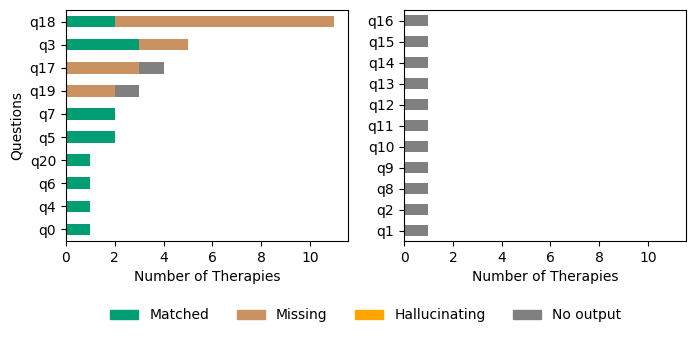

In [76]:
# Convert to DataFrame
df = pd.DataFrame(real_rag_res_cnt_df_5
[['Question_index','Is_there_an_approval','matching_cnt','missing_cnt','hallucinating_cnt','no_output_cnt']])

# add a 'Total' column to sort by
df['total'] = df['matching_cnt'] + df['missing_cnt'] + df['hallucinating_cnt'] + df['no_output_cnt']

# sort by the 'Total' column
df_sorted = df.sort_values(['Is_there_an_approval','total'], ascending=[True, True])

# split into groups
df_true = df[df['Is_there_an_approval'] == True].sort_values('total', ascending=True)
df_false = df[df['Is_there_an_approval'] == False].sort_values('total', ascending=True)

# create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 3), sharex=True)

# set colors
cb_palette = sns.color_palette("colorblind")
colors = [cb_palette[2], cb_palette[5], "orange", "grey"]

# count columns to plot
plot_cnt = ['matching_cnt', 'missing_cnt', 'hallucinating_cnt', 'no_output_cnt']

# set axes background color
ax.set_facecolor('white') 

# change background grid color
ax.grid(visible=True, axis='x', color='lightgray', linestyle='--')

# plot each facet
for ax, subdf, title in zip(axes, [df_true, df_false], ['FDA-approved', 'Not approved']):
    subdf.set_index("Question_index")[plot_cnt]\
        .plot(kind="barh", stacked=True, color=colors, ax=ax, edgecolor=None, legend=False)
    
    # ax.set_title(title)
    ax.set_xlabel("Number of Therapies")
    ax.set_ylabel("Questions")
    
    if title == 'Not approved':
        ax.set_ylabel("")

# create a custom legend
handles = [plt.Rectangle((0,0),1,1, color=col) for col in colors]
legend = fig.legend(handles, ['Matched', 'Missing', 'Hallucinating', 'No output'], 
          title=None, 
          bbox_to_anchor=(0.5, -0.05), ncol=4,
          borderaxespad=1,
          loc='upper center',
          fontsize=10,
          frameon=False
          )
legend.get_frame().set_facecolor('white')

# save
save = False
if save == True:
    plt.savefig(f'./figures/{base_model}/Figure4_realquestions_stackedbar_2.jpeg', dpi=500, bbox_inches='tight')
plt.show()


#### Figure 4D. Radar plot comparing all evaluation metrics

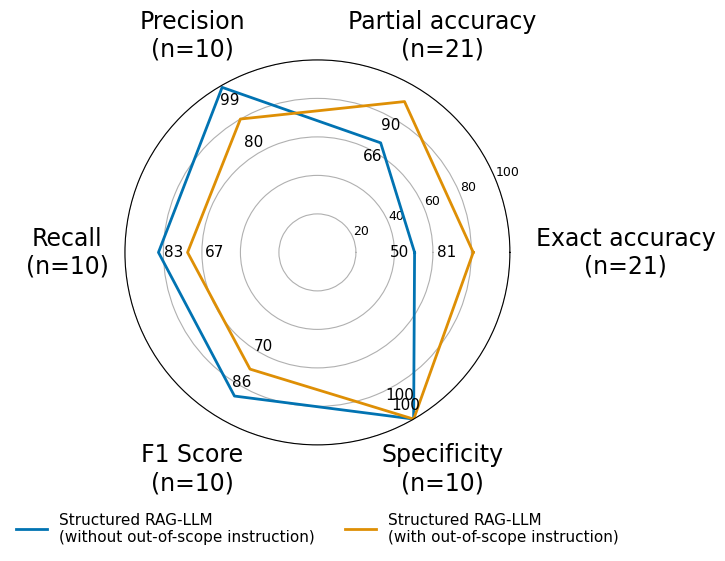

In [77]:
from math import pi
import matplotlib.pyplot as plt

# Color palette
cols=sns.color_palette(cc.glasbey, n_colors=40)

# Metrics
metrics = ['Exact accuracy\n(n=21)', 'Partial accuracy\n(n=21)', 'Precision\n(n=10)', 'Recall\n(n=10)', 'F1 Score\n(n=10)', 'Specificity\n(n=10)']

# strategy 4: without out-of-scope JSON schema instruction (averaged across five runs)
strategy=4
values_without_schema = [
    np.mean([all_real_results[strategy]['full'][run]['avg_exact_match_acc'] for run in range(5)]),
    np.mean([all_real_results[strategy]['full'][run]['avg_partial_match_acc'] for run in range(5)]),
    np.mean([all_real_results[strategy]['full'][run]['avg_precision'] for run in range(5)]),
    np.mean([all_real_results[strategy]['full'][run]['avg_recall'] for run in range(5)]),
    np.mean([all_real_results[strategy]['full'][run]['avg_f1'] for run in range(5)]),
    np.mean([all_real_results[strategy]['full'][run]['avg_specificity'] for run in range(5)])
    ]
values_without_schema = [value*100 for value in values_without_schema] 
values_without_schema += values_without_schema[:1] 

# strategy 5: with out-of-scope JSON schema instruction 
strategy=5
values_with_schema = [
    np.mean([all_real_results[strategy]['full'][run]['avg_exact_match_acc'] for run in range(5)]),
    np.mean([all_real_results[strategy]['full'][run]['avg_partial_match_acc'] for run in range(5)]),
    np.mean([all_real_results[strategy]['full'][run]['avg_precision'] for run in range(5)]),
    np.mean([all_real_results[strategy]['full'][run]['avg_recall'] for run in range(5)]),
    np.mean([all_real_results[strategy]['full'][run]['avg_f1'] for run in range(5)]),
    np.mean([all_real_results[strategy]['full'][run]['avg_specificity'] for run in range(5)])
    ]
values_with_schema = [value*100 for value in values_with_schema] 
values_with_schema += values_with_schema[:1] 

# radar angles
angles = [n / float(len(metrics)) * 2 * pi for n in range(len(metrics))]
angles += angles[:1]

# set color palette
cb_palette = sns.color_palette("colorblind")

# Set up the plot
plt.figure(figsize=(5, 5))
ax = plt.subplot(111, polar=True)

# Plot the models
ax.plot(angles, values_without_schema, color=cb_palette[0], linewidth=2, linestyle='solid', 
        label='RAG-LLM without out-of-scope instruction')
ax.plot(angles, values_with_schema, color=cb_palette[1], linewidth=2, linestyle='solid',
        label='RAG-LLM with out-of-scope instruction')

# annotate each metric value
for i in range(len(metrics)):
    ax.text(angles[i], values_without_schema[i] - 8, 
            f"{values_without_schema[i]:.0f}",
            color='black', fontsize=11, ha='center', va='center')
    ax.text(angles[i], values_with_schema[i] - 14, 
            f"{values_with_schema[i]:.0f}",
            color='black', fontsize=11, ha='center', va='center')

# labels and ticks
ax.set_ylim(0, 100)
ax.tick_params(axis='y', labelsize=9)
ax.set_xticks([])
for i, metric in enumerate(metrics): # Manually set the position of the labels outside the chart
    angle = angles[i]  
    if angle == 0:  
        ax.text(angle, 160, metric, horizontalalignment='center', verticalalignment='center', fontsize=17)       
    else:
        ax.text(angle, 130, metric, horizontalalignment='center', verticalalignment='center', fontsize=17)       

# create a custom legend
from matplotlib.lines import Line2D
handles = [Line2D([0], [0], color=col, linewidth=2) for col in [cb_palette[0], cb_palette[1]]]
legend = ax.legend(handles, ['Structured RAG-LLM\n(without out-of-scope instruction)', 'Structured RAG-LLM\n(with out-of-scope instruction)'], 
          title=False, 
          bbox_to_anchor=(0.5, -0.12), ncol=2,
          frameon=False,
          borderaxespad=1,
          loc='upper center',
          fontsize=11
          ) 
legend.get_frame().set_facecolor('white')

# save plot
save = False
if save == True:
    plt.savefig(f'./figures/{base_model}/Figure4_ragllmRealworldPerformance_radar.jpeg', dpi=600, bbox_inches='tight')

plt.show()

#### Run McNemar's test on accuracies from real-world assessment

In [78]:
# Create contingency table
exact_table_ls=[]
partial_table_ls=[]

for i in range(5):
    exact_table_ls.append(create_mcnemar_table(
        all_real_results[4]['exact'][i], 
        all_real_results[5]['exact'][i]
        )
                          )
    
    partial_table_ls.append(create_mcnemar_table(
        all_real_results[4]['partial'][i], 
        all_real_results[5]['partial'][i]
        )
                            )

In [ ]:
exact_result_ls=[]
partial_result_ls=[]
exact_result_pval=[]
partial_result_pval=[]
exact_result_bc=[]
partial_result_bc=[]
pooled_exact = np.array([[0, 0], [0, 0]])
pooled_partial = np.array([[0, 0], [0, 0]])

for i in range(5):
    # run mcnemar's test separately
    exact_result, exact_bc = conduct_mcnemar_test(exact_table_ls[i])
    partial_result, partial_bc = conduct_mcnemar_test(partial_table_ls[i])
    exact_result_ls.append(exact_result)
    partial_result_ls.append(partial_result)
    
    # pool matrix
    pooled_exact += np.array(exact_table_ls[i])
    pooled_partial += np.array(partial_table_ls[i])

    # mcnemar's p-values
    exact_result_pval.append(exact_result.pvalue)
    partial_result_pval.append(partial_result.pvalue)
    
    # get discordant (b,c) values (if b > c, model A is better)
    exact_result_bc.append(exact_bc)
    partial_result_bc.append(partial_bc)

# run mcnemar's test on pooled matrix
pooled_exact_result, pooled_exact_bc = conduct_mcnemar_test(pooled_exact) 
pooled_partial_result, pooled_partial_bc = conduct_mcnemar_test(pooled_partial)

print(f'Exact: {print_mcnemar_res(pooled_exact_result, alpha=0.05)}')
print(f'Partial: {print_mcnemar_res(pooled_partial_result, alpha=0.05)}')


Exact: Significance: True; Test Statistic: 24.025; P-value: 9.509294351575039e-07
Partial: Significance: True; Test Statistic: 13.58695652173913; P-value: 0.00022776260245036984


In [84]:
# multiple test correction
_, p_corrected, _, _ = multipletests([pooled_exact_result.pvalue, pooled_partial_result.pvalue], alpha=0.05, method='fdr_bh')
p_corrected

array([1.90185887e-06, 2.27762602e-04])

##### Calculate mean precision, recall, F1 score

In [85]:
def compute_metric_mean(metric_name, results_dict, strategy, idx_list, n_runs: int=5) -> float:
    """Compute the mean of a metric over selected questions (e.g. with on-label FDA-approved drugs) across multiple runs"""
    means = []
    for x in range(n_runs):
        values = [
            val for i, val in enumerate(results_dict[strategy]['full'][x][metric_name])
            if i in idx_list
        ]
        means.append(np.mean(values))
    return np.mean(means)

fda_questions_idx = real_questions[real_questions['Is_there_an_approval'] == True].index


In [86]:
# Strategy 4 - without out-of-scope JSON schema instruction
for metric in ['precision_ls','recall_ls','f1_ls']:
    avg = compute_metric_mean(
        metric_name=metric,
        results_dict=all_real_results,
        strategy=4,
        idx_list=fda_questions_idx
        )
    print(f"Avg {metric.replace('_ls','').capitalize()}: {avg*100:.4f}")
print(f"Exact acc: {np.sum([all_real_results[4]['full'][0]['exact_match_acc'][ind] for ind in fda_questions_idx])/len(fda_questions_idx) * 100}")
print(f"Partial acc: {np.sum([all_real_results[4]['full'][0]['partial_match_acc'][ind] for ind in fda_questions_idx])/len(fda_questions_idx) * 100}")

Avg Precision: 99.0000
Avg Recall: 82.5758
Avg F1: 86.1667
Exact acc: 70.0
Partial acc: 100.0


In [87]:
# Strategy 5 - with out-of-scope schema instruction
for metric in ['precision_ls','recall_ls','f1_ls']:
    avg = compute_metric_mean(
        metric_name=metric,
        results_dict=all_real_results,
        strategy=5,
        idx_list=fda_questions_idx
        )
    print(f"Avg {metric.replace('_ls','').capitalize()}: {avg*100:.4f}")
print(f"Exact acc: {np.sum([all_real_results[5]['full'][0]['exact_match_acc'][ind] for ind in fda_questions_idx])/len(fda_questions_idx) * 100}")
print(f"Partial acc: {np.sum([all_real_results[5]['full'][0]['partial_match_acc'][ind] for ind in fda_questions_idx])/len(fda_questions_idx) * 100}")

Avg Precision: 80.0000
Avg Recall: 67.4545
Avg F1: 70.0128
Exact acc: 60.0
Partial acc: 80.0


#### Figure S1. Distribution of structured/unstructured context length

In [91]:
# function to calculate IQR (interquartile range)
def calc_iqr(chunk_size_list):
    q1 = np.percentile(chunk_size_list, 25)
    q3 = np.percentile(chunk_size_list, 75)
    iqr = f'{q1}-{q3}'
    return(iqr)

# import tiktoken
import tiktoken
encoding = tiktoken.encoding_for_model("gpt-4o")  # or "gpt-4", "gpt-3.5-turbo", etc.

Unstructured dataset

In [89]:
# load unstructured context derived from FDA drug label indication and usage sections (deduplicated, full)
with open(os.path.join(root_dir,"data/unstructured_context_chunks.json"), "r") as f:
    unstructured_dataset = json.load(f)
    
len(unstructured_dataset)

56

# chunks: 56
Min: 47
Max: 2476
Mean: 238.16071428571428
Median: 162.0
IQR: 126.75-239.5


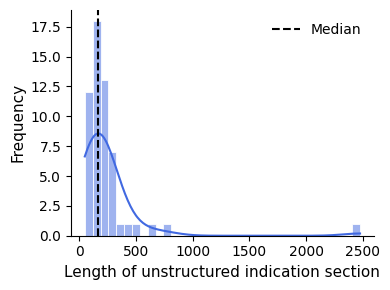

In [93]:
# get chunk size in tokens
unstruc_chunk_size=[len(encoding.encode(chunk)) for chunk in unstructured_dataset]
print("# chunks: "+str(len(unstruc_chunk_size)))
print("Min: "+str(np.min(unstruc_chunk_size)))
print("Max: "+str(np.max(unstruc_chunk_size)))
print("Mean: "+str(np.mean(unstruc_chunk_size)))
print("Median: "+str(np.median(unstruc_chunk_size)))
print("IQR: "+str(calc_iqr(unstruc_chunk_size)))

# set figure size and subplot
plt.rcParams["figure.figsize"] = [3.5, 3]
fig, ax = plt.subplots(tight_layout=True, figsize=(4,3))

# set color palette
cols=sns.color_palette(cc.glasbey, n_colors=40)

# histogram with KDE
n_bins=35
sns.histplot(unstruc_chunk_size, bins=n_bins, kde=True, stat='count',
             color='royalblue', alpha=0.5, edgecolor='white', ax=ax)

# median line
plt.axvline(np.median(unstruc_chunk_size), color='black', 
            linestyle='--', linewidth=1.5, label='Median', alpha=1)

# x, y labels and ticks
ax.set_xlabel('Length of unstructured indication section', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11) # raw counts

# remove top and right border
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# add the legend
# plt.legend()
ax.legend(ncol=1, frameon=False)

# save plot
save = False
if save == True:
    plt.savefig('./figures/FigureS1_unstructuredlength_dist.jpeg', dpi=500, bbox_inches='tight')

plt.show()


Structured dataset

In [94]:
# load structured context derived from moalmanac data fields
with open(os.path.join(root_dir,"data/structured_context_chunks.json"), "r") as f:
    structured_dataset = json.load(f)

len(structured_dataset)

234

# chunks: 234
Min: 130
Max: 284
Mean: 187.10683760683762
Median: 181.0
IQR: 165.0-203.5


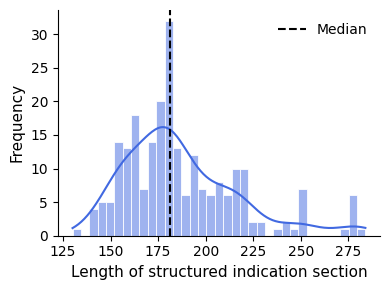

In [95]:
# get chunk size
struc_chunk_size=[len(encoding.encode(chunk)) for chunk in structured_dataset]
print("# chunks: "+str(len(struc_chunk_size)))
print("Min: "+str(np.min(struc_chunk_size)))
print("Max: "+str(np.max(struc_chunk_size)))
print("Mean: "+str(np.mean(struc_chunk_size)))
print("Median: "+str(np.median(struc_chunk_size)))
print("IQR: "+str(calc_iqr(struc_chunk_size)))

# set figure size and subplot
plt.rcParams["figure.figsize"] = [3.5, 3]
fig, ax = plt.subplots(tight_layout=True, figsize=(4,3))

# set color palette
cols=sns.color_palette(cc.glasbey, n_colors=40)

# histogram with KDE
n_bins=35
sns.histplot(struc_chunk_size, bins=n_bins, kde=True, stat='count',
             color='royalblue', alpha=0.5, edgecolor='white', ax=ax)

# median line
plt.axvline(np.median(struc_chunk_size), color='black', 
            linestyle='--', linewidth=1.5, label='Median', alpha=1)

# x, y labels and ticks
ax.set_xlabel('Length of structured indication section', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11) # raw counts

# remove top and right border
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# add legend
ax.legend(ncol=1, frameon=False)

# save plot
save = False
if save == True:
    plt.savefig('./figures/FigureS1_structuredlength_dist.jpeg', dpi=500, bbox_inches='tight')

plt.show()


#### Supplementary Note 1-2. Example of synthetic prompt and output from RAG-LLM 

##### Unstructured version

In [116]:
# Input prompt
print(rag_unstruc_res_dict_0['input prompt'][0][180])


    Context information is below.
    ---------------------
    ['INDICATIONS AND USAGE  --------------------------  \nLynparza is a poly (ADP-ribose) polymerase (PARP) inhibitor indicated: \nOvarian cancer \n• for the maintenance treatment of adult patients with deleterious or \nsuspected deleterious germline or somatic BRCA-mutated advanced \nepithelial ovarian, fallopian tube or primary peritoneal cancer who are in \ncomplete or partial response to first-line platinum-based chemotherapy. \nSelect patients for therapy based on an FDA-approved companion \ndiagnostic for Lynparza. (1.1, 2.1) \n• in combination with bevacizumab for the maintenance treatment of adult \npatients with advanced epithelial ovarian, fallopian tube or primary \nperitoneal cancer who are in complete or partial response to first-line \nplatinum-based chemotherapy and whose cancer is associated with \nhomologous recombination deficiency (HRD)-positive status defined by \neither: \n• a deleterious or suspected de

In [117]:
# RAG-LLM response
print(rag_unstruc_res_dict_0['full output'][0][180])

{
    "Treatment 1": {
        "Disease Name": "Prostate Cancer",
        "Disease Phase or Condition": "Metastatic Castration-Resistant",
        "Drug Name": "Lynparza",
        "Prior Treatment or Resistance Status": "Progressed following prior treatment with enzalutamide or abiraterone",
        "Genomic Features": "Deleterious or suspected deleterious germline or somatic homologous recombination repair (HRR) gene-mutated",
        "Link to FDA-approved Label": "https://www.fda.gov/drugsatfda"
    },
    "Treatment 2": {
        "Disease Name": "Prostate Cancer",
        "Disease Phase or Condition": "Metastatic Castration-Resistant",
        "Drug Name": "Lynparza in combination with abiraterone and prednisone or prednisolone",
        "Prior Treatment or Resistance Status": "None specified",
        "Genomic Features": "Deleterious or suspected deleterious BRCA-mutated (BRCAm)",
        "Link to FDA-approved Label": "https://www.fda.gov/drugsatfda"
    },
    "Treatment 3": {
   

##### Structured version

In [118]:
# Input prompt
print(rag_struc_res_dict_0['input prompt'][0][180])


    Context information is below.
    ---------------------
    ['If a prostate cancer patient has a somatic variant in gene BRCA1, and is metastatic castration-resistant, one recommended treatment would be Abiraterone + Prednisone + Olaparib. The U.S. Food and Drug Administration (FDA) has granted approval to olaparib in combination with abiraterone and prednisone or prednisolone for the treatment of adult patients with deleterious or suspected deleterious BRCA-mutated (BRCAm) metastatic castration-resistant prostate cancer (mCRPC). (Citation: AstraZeneca Pharmaceuticals, LP. Lynparza (olaparib) [package insert]. U.S. Food and Drug Administration website. https://www.accessdata.fda.gov/drugsatfda_docs/label/2023/208558s025lbl.pdf. Revised May 2023. Accessed July 5, 2023.).', 'If a prostate cancer patient has a somatic variant in gene BRCA2, and is metastatic castration-resistant, one recommended treatment would be Abiraterone + Prednisone + Olaparib. The U.S. Food and Drug Administra

In [119]:
# RAG-LLM response 
print(rag_struc_res_dict_0['full output'][0][180])

{
    "Treatment 1": {
        "Disease Name": "Prostate Cancer",
        "Disease Phase or Condition": "Metastatic Castration-Resistant",
        "Drug Name": "Abiraterone + Prednisone + Olaparib",
        "Prior Treatment or Resistance Status": "Not specified",
        "Genomic Features": "Somatic variant in gene BRCA1",
        "Link to FDA-approved Label": "https://www.accessdata.fda.gov/drugsatfda_docs/label/2023/208558s025lbl.pdf"
    },
    "Treatment 2": {
        "Disease Name": "Prostate Cancer",
        "Disease Phase or Condition": "Metastatic Castration-Resistant",
        "Drug Name": "Enzalutamide + Talazoparib",
        "Prior Treatment or Resistance Status": "Not specified",
        "Genomic Features": "Somatic variant in gene BRCA1",
        "Link to FDA-approved Label": "https://www.accessdata.fda.gov/drugsatfda_docs/label/2023/211651s010lbl.pdf"
    },
    "Treatment 3": {
        "Disease Name": "Prostate Cancer",
        "Disease Phase or Condition": "Metastatic C

Quick error analysis

In [126]:
exact_failed=[i for i, e in enumerate(struc_results['exact_match_acc']) if e == False]
for i in exact_failed:
    print(f"Input prompt: {rag_struc_res_dict_0['input prompt'][0][i]}")
    print(f"RAG-LLM output: {rag_struc_res_dict_0['full output'][0][i]}")
    print(f"True drugs: {struc_results['true_drugs_generic_set_ls'][i]}")
    print(f"Predicted drugs: {struc_results['pred_drugs_generic_set_ls'][i]}")

Input prompt: 
    Context information is below.
    ---------------------
    ['If a epithelial ovarian cancer patient has a somatic variant in gene BRCA1, and is hrd-positive advanced, one recommended treatment would be Bevacizumab + Olaparib. The U.S. Food and Drug Administration expanded the indication of olaparib to include its combination with bevacizumab for first-line maintenance treatment of adults with advanced epithelial ovarian, fallopian tube, or primary peritoneal cancer who are in complete or partial response to first-line platinum-based chemotherapy and whose cancer is associated with homologous recombination deficiency positive status defined by either a deleterious or suspected deleterious BRCA mutation, and/or genomic instability. (Citation: AstraZeneca Pharmaceuticals, LP. Lynparza (olaparib) [package insert]. U.S. Food and Drug Administration website. https://www.accessdata.fda.gov/drugsatfda_docs/label/2023/208558s025lbl.pdf. Revised May 2023. Accessed July 5, 202

In [121]:
counts = moalmanac_data.iloc[exact_failed]['disease'].value_counts()
proportions = moalmanac_data.iloc[exact_failed]['disease'].value_counts(normalize=True)
pd.DataFrame({'count': counts, 'proportion': proportions})

,count,proportion
disease,,
Ovarian Cancer,5,0.384615
Acute Myeloid Leukemia,5,0.384615
Breast Cancer,3,0.230769


In [122]:
counts = moalmanac_data.iloc[exact_failed]['therapy_strategy'].value_counts()
proportions = moalmanac_data.iloc[exact_failed]['therapy_strategy'].value_counts(normalize=True)
pd.DataFrame({'count': counts, 'proportion': proportions})

,count,proportion
therapy_strategy,,
PARP inhibition,5,0.384615
IDH1 inhibition,5,0.384615
PI3K/AKT/mTOR inhibition,1,0.076923
Taxane-based chemotherapy + ER signaling inhibition,1,0.076923
ER signaling inhibition + Chemotherapy,1,0.076923


#### Supplementary Note 3. Example real-world query without FDA-approved drugs available

In [125]:
for i in range(len(real_questions)):
    if real_questions.loc[i, 'Is_there_an_approval'] == False:
        print(f"Input prompt: {all_real_results[5]['ragllm_input'][0][i]}")
        print(f"RAG-LLM output: {all_real_results[5]['ragllm_output'][0][i]}")
        print(f"True drugs: {real_prompt_groundtruth_dict[real_questions.loc[i, 'prompt']]}")
        print(f"Predicted drugs: {all_real_results[5]['full'][0]['pred_drugs_generic_set_ls'][i]}")

Input prompt: 
    Context information is below.
    ---------------------
    ['If a prostate cancer patient has a somatic variant in gene RAD54L, and is metastatic castration resistant prostate cancer, one recommended treatment would be Olaparib. The U.S. Food and Drug Administration (FDA) granted approval to olaparib for adult patients with deleterious or suspected deleterous germline or somatic homologous recombination repair (HRR) gene-mutated metastatic castration-resistant prostate cancer (mCRPC), who have progressed following prior treatment with enzalutamide or abiraterone. (Citation: AstraZeneca Pharmaceuticals, LP. Lynparza (olaparib) [package insert]. U.S. Food and Drug Administration website. https://www.accessdata.fda.gov/drugsatfda_docs/label/2023/208558s025lbl.pdf. Revised May 2023. Accessed July 5, 2023.).', 'If a prostate cancer patient has a somatic variant in gene RAD51D, and is metastatic castration resistant prostate cancer, one recommended treatment would be Olap

In [30]:
# An example of real-world expert query without FDA-approved drugs available
i=2
print(real_rag_res_dict_4['input prompt'][0][i])


    Context information is below.
    ---------------------
    ['If a anaplastic large cell lymphoma (alcl) patient has a rearrangement in gene ALK, one recommended treatment would be Crizotinib. The U.S. Food and Drug Administration (FDA) granted approval to crizotinib for the treatment of pediatric patients 1 year of age or older and young adults with relapsed or refactory, systemic anaplastic large cell lymphoma (ALCL) that is ALK-positive. The safety and efficacy of crizotinib have not been established in older adults with relapsed or refactory systemic ALK-positive ALCL. (Citation: Pfizer, Inc. Xalkori (crizotinib) [package insert]. U.S. Food and Drug Administration website. https://www.accessdata.fda.gov/drugsatfda_docs/label/2022/202570s033lbl.pdf. Revised July 2022. Accessed August 4th, 2022.).', 'If a inflammatory myofibroblastic tumor (imt) patient has a rearrangement in gene ALK, one recommended treatment would be Crizotinib. The U.S. Food and Drug Administration (FDA) gra

In [127]:
# Full RAG-LLM's response from the corresponding real-world query
i=2
print(real_rag_res_dict_4['full output'][0][i])

{
    "Treatment 1": {
        "Disease Name": "Anaplastic Large Cell Lymphoma (ALCL)",
        "Disease Phase or Condition": "Relapsed or refractory, systemic",
        "Drug Name": "Crizotinib",
        "Prior Treatment or Resistance Status": "Relapsed or refractory",
        "Genomic Features": "ALK-positive",
        "FDA-approval status": "Approved",
        "Link to FDA-approved Label": "https://www.accessdata.fda.gov/drugsatfda_docs/label/2022/202570s033lbl.pdf"
    },
    "Treatment 2": {
        "Disease Name": "Inflammatory Myofibroblastic Tumor (IMT)",
        "Disease Phase or Condition": "Unresectable, recurrent, or refractory",
        "Drug Name": "Crizotinib",
        "Prior Treatment or Resistance Status": "Unresectable, recurrent, or refractory",
        "Genomic Features": "ALK-positive",
        "FDA-approval status": "Approved",
        "Link to FDA-approved Label": "https://www.accessdata.fda.gov/drugsatfda_docs/label/2022/202570s033lbl.pdf"
    },
    "Treatment 

After specifying a JSON schema for no approvals

In [128]:
# An example of real-world expert query without FDA-approved drugs available
i=2
print(real_rag_res_dict_5['input prompt'][0][i])
print(real_rag_res_dict_5['full output'][0][i])


    Context information is below.
    ---------------------
    ['If a anaplastic large cell lymphoma (alcl) patient has a rearrangement in gene ALK, one recommended treatment would be Crizotinib. The U.S. Food and Drug Administration (FDA) granted approval to crizotinib for the treatment of pediatric patients 1 year of age or older and young adults with relapsed or refactory, systemic anaplastic large cell lymphoma (ALCL) that is ALK-positive. The safety and efficacy of crizotinib have not been established in older adults with relapsed or refactory systemic ALK-positive ALCL. (Citation: Pfizer, Inc. Xalkori (crizotinib) [package insert]. U.S. Food and Drug Administration website. https://www.accessdata.fda.gov/drugsatfda_docs/label/2022/202570s033lbl.pdf. Revised July 2022. Accessed August 4th, 2022.).', 'If a inflammatory myofibroblastic tumor (imt) patient has a rearrangement in gene ALK, one recommended treatment would be Crizotinib. The U.S. Food and Drug Administration (FDA) gra

#### Merge real-world results for supplementary table

In [129]:
def create_selected_output_df(all_results_dict, selected_output, column_prefix):
    df = pd.DataFrame.from_dict(all_results_dict[selected_output]).T
    df = df.add_prefix(column_prefix)
    return(df)

strategy=5
input_df=create_selected_output_df(all_real_results[strategy], 'ragllm_input', 'RAGLLM_input_prompt_')
full_output_df=create_selected_output_df(all_real_results[strategy], 'ragllm_output', 'RAGLLM_full_output_')

pred_drug_output_ls = list()
for i in range(len(all_real_results[strategy]['full'])):
    pred_drug_output_ls.append(all_real_results[strategy]['full'][i]['pred_drugs_generic_set_ls'])

drug_output_df=pd.DataFrame(pred_drug_output_ls).T.add_prefix('RAGLLM_drug_output_')

In [130]:
real_supp_df = pd.concat([real_rag_res_cnt_df_5, drug_output_df, full_output_df, input_df], axis=1)
real_supp_df.to_csv(f"./{base_model}_real_supp_df.csv", index=False)
real_supp_df

,Question_index,prompt,Asking_therapy,Given_biomarker,Question_category,Is_there_an_approval,Groundtruth_answers,Groundtruth_therapies,matching_cnt,missing_cnt,...,RAGLLM_full_output_0,RAGLLM_full_output_1,RAGLLM_full_output_2,RAGLLM_full_output_3,RAGLLM_full_output_4,RAGLLM_input_prompt_0,RAGLLM_input_prompt_1,RAGLLM_input_prompt_2,RAGLLM_input_prompt_3,RAGLLM_input_prompt_4
0,q0,What is the first-line treatment of metastatic...,True,True,"given disease and biomarker, return drugs",True,erdafitinib,[{'erdafitinib'}],1,0,...,"{\n ""Status"": ""success"",\n ""Treatment 1""...","{\n ""Status"": ""success"",\n ""Treatment 1""...","{\n ""Status"": ""success"",\n ""Treatment 1""...","{\n ""Status"": ""success"",\n ""Treatment 1""...","{\n ""Status"": ""success"",\n ""Treatment 1""...",\n Context information is below.\n -----...,\n Context information is below.\n -----...,\n Context information is below.\n -----...,\n Context information is below.\n -----...,\n Context information is below.\n -----...
1,q1,Are PARP inhibitors used for patients with lei...,True,True,"given disease and biomarker, return drugs",False,PARP inhibitors are not yet approved for the t...,[],0,0,...,"{\n ""Status"": ""no_match"",\n ""Message"": ""...","{\n ""Status"": ""no_match"",\n ""Message"": ""...","{\n ""Status"": ""no_match"",\n ""Message"": ""...","{\n ""Status"": ""no_match"",\n ""Message"": ""...","{\n ""Status"": ""no_match"",\n ""Message"": ""...",\n Context information is below.\n -----...,\n Context information is below.\n -----...,\n Context information is below.\n -----...,\n Context information is below.\n -----...,\n Context information is below.\n -----...
2,q2,Are ALK inhibitors approved for use in TFCP2 f...,True,True,"given disease and biomarker, return drugs",False,"No, no ALK inhibitors are currently approved f...",[],0,0,...,"{\n ""Status"": ""no_match"",\n ""Message"": ""...","{\n ""Status"": ""no_match"",\n ""Message"": ""...","{\n ""Status"": ""no_match"",\n ""Message"": ""...","{\n ""Status"": ""no_match"",\n ""Message"": ""...","{\n ""Status"": ""no_match"",\n ""Message"": ""...",\n Context information is below.\n -----...,\n Context information is below.\n -----...,\n Context information is below.\n -----...,\n Context information is below.\n -----...,\n Context information is below.\n -----...
3,q3,For a patient with cancer metastatic prostate ...,True,True,"given disease and biomarker, return drugs",True,The following therapy and combination therapie...,"[{'olaparib'}, {'prednisone', 'olaparib', 'abi...",3,2,...,"{\n ""Status"": ""success"",\n ""Treatment 1""...","{\n ""Status"": ""success"",\n ""Treatment 1""...","{\n ""Status"": ""success"",\n ""Treatment 1""...","{\n ""Status"": ""success"",\n ""Treatment 1""...","{\n ""Status"": ""success"",\n ""Treatment 1""...",\n Context information is below.\n -----...,\n Context information is below.\n -----...,\n Context information is below.\n -----...,\n Context information is below.\n -----...,\n Context information is below.\n -----...
4,q4,For a patient with HER2+ breast cancer after n...,True,True,"given disease and biomarker, return drugs; HER...",True,TDM-1 (ado-trastuzumab emtansine (Kadcyla)),[{'ado-trastuzumab emtansine'}],1,0,...,"{\n ""Status"": ""success"",\n ""Treatment 1""...","{\n ""Status"": ""success"",\n ""Treatment 1""...","{\n ""Status"": ""success"",\n ""Treatment 1""...","{\n ""Status"": ""success"",\n ""Treatment 1""...","{\n ""Status"": ""success"",\n ""Treatment 1""...",\n Context information is below.\n -----...,\n Context information is below.\n -----...,\n Context information is below.\n -----...,\n Context information is below.\n -----...,\n Context information is below.\n -----...
5,q5,For patients with advanced cancer and with NTR...,True,True,"given disease and biomarker, return drugs",True,"Yes, the TRK inhibitors Entrectinib and Larotr...","[{'entrectinib'}, {'larotrectinib'}]",2,0,...,"{\n ""Status"": ""success"",\n ""Treatment 1""...","{\n ""Sta

In [131]:
strategy=4
input_df=create_selected_output_df(all_real_results[strategy], 'ragllm_input', 'RAGLLM_input_prompt_')
full_output_df=create_selected_output_df(all_real_results[strategy], 'ragllm_output', 'RAGLLM_full_output_')

pred_drug_output_ls = list()
for i in range(len(all_real_results[strategy]['full'])):
    pred_drug_output_ls.append(all_real_results[strategy]['full'][i]['pred_drugs_generic_set_ls'])

drug_output_df=pd.DataFrame(pred_drug_output_ls).T.add_prefix('RAGLLM_drug_output_')

In [132]:
real_supp_df = pd.concat([real_rag_res_cnt_df_4, drug_output_df, full_output_df, input_df], axis=1)
real_supp_df.to_csv(f"./{base_model}_real_4_supp_df.csv", index=False)
real_supp_df

,Question_index,prompt,Asking_therapy,Given_biomarker,Question_category,Is_there_an_approval,Groundtruth_answers,Groundtruth_therapies,matching_cnt,missing_cnt,...,RAGLLM_full_output_0,RAGLLM_full_output_1,RAGLLM_full_output_2,RAGLLM_full_output_3,RAGLLM_full_output_4,RAGLLM_input_prompt_0,RAGLLM_input_prompt_1,RAGLLM_input_prompt_2,RAGLLM_input_prompt_3,RAGLLM_input_prompt_4
0,q0,What is the first-line treatment of metastatic...,True,True,"given disease and biomarker, return drugs",True,erdafitinib,[{'erdafitinib'}],1,0,...,"{\n ""Treatment 1"": {\n ""Disease Name...","{\n ""Treatment 1"": {\n ""Disease Name...","{\n ""Treatment 1"": {\n ""Disease Name...","{\n ""Treatment 1"": {\n ""Disease Name...","{\n ""Treatment 1"": {\n ""Disease Name...",\n Context information is below.\n -----...,\n Context information is below.\n -----...,\n Context information is below.\n -----...,\n Context information is below.\n -----...,\n Context information is below.\n -----...
1,q1,Are PARP inhibitors used for patients with lei...,True,True,"given disease and biomarker, return drugs",False,PARP inhibitors are not yet approved for the t...,[],0,0,...,"{\n ""There are no FDA-approved drugs for th...","{\n ""There are no FDA-approved drugs for th...","{\n ""There are no FDA-approved drugs for th...","{\n ""There are no FDA-approved drugs for th...","{\n ""There are no FDA-approved drugs for th...",\n Context information is below.\n -----...,\n Context information is below.\n -----...,\n Context information is below.\n -----...,\n Context information is below.\n -----...,\n Context information is below.\n -----...
2,q2,Are ALK inhibitors approved for use in TFCP2 f...,True,True,"given disease and biomarker, return drugs",False,"No, no ALK inhibitors are currently approved f...",[],0,0,...,"{\n ""Treatment 1"": {\n ""Disease Name...","{\n ""There are no FDA-approved drugs for th...","{\n ""There are no FDA-approved drugs for th...","{\n ""There are no FDA-approved drugs for th...","{\n ""Treatment 1"": {\n ""Disease Name...",\n Context information is below.\n -----...,\n Context information is below.\n -----...,\n Context information is below.\n -----...,\n Context information is below.\n -----...,\n Context information is below.\n -----...
3,q3,For a patient with cancer metastatic prostate ...,True,True,"given disease and biomarker, return drugs",True,The following therapy and combination therapie...,"[{'olaparib'}, {'prednisone', 'olaparib', 'abi...",3,2,...,"{\n ""Treatment 1"": {\n ""Disease Name...","{\n ""Treatment 1"": {\n ""Disease Name...","{\n ""Treatment 1"": {\n ""Disease Name...","{\n ""Treatment 1"": {\n ""Disease Name...","{\n ""Treatment 1"": {\n ""Disease Name...",\n Context information is below.\n -----...,\n Context information is below.\n -----...,\n Context information is below.\n -----...,\n Context information is below.\n -----...,\n Context information is below.\n -----...
4,q4,For a patient with HER2+ breast cancer after n...,True,True,"given disease and biomarker, return drugs; HER...",True,TDM-1 (ado-trastuzumab emtansine (Kadcyla)),[{'ado-trastuzumab emtansine'}],1,0,...,"{\n ""Treatment 1"": {\n ""Disease Name...","{\n ""Treatment 1"": {\n ""Disease Name...","{\n ""Treatment 1"": {\n ""Disease Name...","{\n ""Treatment 1"": {\n ""Disease Name...","{\n ""Treatment 1"": {\n ""Disease Name...",\n Context information is below.\n -----...,\n Context information is below.\n -----...,\n Context information is below.\n -----...,\n Context information is below.\n -----...,\n Context information is below.\n -----...
5,q5,For patients with advanced cancer and with NTR...,True,True,"given disease and biomarker, return drugs",True,"Yes, the TRK inhibitors Entrectinib and Larotr...","[{'entrectinib'}, {'larotrectinib'}]",2,0,...,"{\n ""Treatment 1"": {\n ""Disease Name...","{\n ""Treatment 1"": {\n ""Disease Name...","{\n ""Treatment 1"": {\n ""Disease Name...","{\n ""Treatment 1"": {\n ""Disease Name...","{\n ""Treatment 1"": {\n "